## COVID-19 country comparison

In [2]:
import requests
import pandas as pd
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from IPython.display import display
import datetime
import math
import numpy as np
from scipy.optimize import curve_fit
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
matplotlib.rcParams['figure.figsize'] = (14, 8)
cm = plt.cm.get_cmap('nipy_spectral')

data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

def set_y_axis_format(log=True):
    if log:
        plt.yscale("log")
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))

### Retrieve the latest version of the data and transform it into a Pandas dataframe

Show the first few rows of the dataframe for illustration

In [3]:
r = requests.get(data_url)
s = StringIO(r.text)
df = pd.read_csv(s, sep=",")

# Add in early data for China from wikipedia:
# https://en.wikipedia.org/wiki/Timeline_of_the_2019%E2%80%9320_coronavirus_outbreak_in_December_2019_%E2%80%93_January_2020

df.loc[df.iloc[:,0] == "Hubei", "1/17/20"] = 45
df.loc[df.iloc[:,0] == "Hubei", "1/18/20"] = 62
df.loc[df.iloc[:,0] == "Hubei", "1/20/20"] = 218
df = df.reindex(list(df.columns[:4]) +\
                list(sorted(df.columns[4:], key=lambda d: datetime.datetime.strptime(d, "%m/%d/%y"))), axis=1)
display(df.iloc[:15, :])

with pd.option_context("display.max_rows", 5, "display.max_columns", 15):
    display(df)

,Province/State,Country/Region,Lat,Long,1/17/20,1/18/20,1/20/20,1/22/20,1/23/20,1/24/20,...,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
0,Anhui,Mainland China,31.82570,117.2264,NaN,NaN,NaN,1,9,15,...,989,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.18240,116.4142,NaN,NaN,NaN,14,22,36,...,410,410,411,413,414,414,418,418,422,426
2,Chongqing,Mainland China,30.05720,107.8740,NaN,NaN,NaN,6,9,27,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.07890,117.9874,NaN,NaN,NaN,1,5,10,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.06110,103.8343,NaN,NaN,NaN,0,2,2,...,91,91,91,91,91,91,91,102,119,120
5,Guangdong,Mainland China,23.34170,113.4244,NaN,NaN,NaN,26,32,53,...,1347,1348,1349,1349,1350,1350,1350,1351,1352,1352
6,Guangxi,Mainland China,23.82980,108.7881,NaN,NaN,NaN,2,5,23,...,252,252,252,252,252,252,252,252,252,252
7,Guizhou,Mainland China,26.81540,106.8748,NaN,NaN,NaN,1,3,3,...,146,146,146,146,146,146,146,146,146,146
8,Hainan,Mainland China,19.19590,109.7453,NaN,NaN,NaN,4,5,8,...,168,168,168,168,168,168,168,168,168,168
9,Hebei,Mainland China,38.04280,114.5149,NaN,NaN,NaN,1,1,2,...,317,318,318,318,318,318,318,318,318,318


,Province/State,Country/Region,Lat,Long,1/17/20,1/18/20,1/20/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
0,Anhui,Mainland China,31.8257,117.2264,NaN,NaN,NaN,...,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,NaN,NaN,NaN,...,413,414,414,418,418,422,426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,"Tulsa County, OK",US,36.1593,-95.9410,NaN,NaN,NaN,...,0,0,0,0,0,0,1
224,"Montgomery County, TX",US,30.3213,-95.4778,NaN,NaN,NaN,...,0,0,0,0,0,0,0


### Add up all provinces/states into one row per country 

In [4]:
by_country = df.groupby("Country/Region").sum()                           # Group by country
dates = by_country.columns[2:]                                            # Drop Lat/Long columns
by_country.loc["Outside China", dates] =\
    by_country.sum().loc[dates]-by_country.loc["Mainland China", dates]   # Add "Outside China" row
by_country = by_country.loc[:, dates].astype(int)                         # Convert to integers
dates = pd.to_datetime(dates)
by_country.columns = dates
with pd.option_context("display.max_rows", 15, "display.max_columns", 10):
    display(by_country)

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07
Country/Region,,,,,,,,,,,
Afghanistan,0,0,0,0,0,...,1,1,1,1,1
Algeria,0,0,0,0,0,...,5,12,12,17,17
Andorra,0,0,0,0,0,...,1,1,1,1,1
Argentina,0,0,0,0,0,...,1,1,1,2,8
Armenia,0,0,0,0,0,...,1,1,1,1,1
Australia,0,0,0,0,0,...,39,52,55,60,63
Austria,0,0,0,0,0,...,21,29,41,55,79
...,...,...,...,...,...,...,...,...,...,...,...
UK,0,0,0,0,0,...,51,85,115,163,206


### List all countries in the `by_country` table

In [5]:
for i, k in enumerate(by_country.index):
    if len(k) > 15:
        k = k[:15] + "."
    print(f"{k:17}", end=" " if (i+1) % 5 else "\n")

Afghanistan       Algeria           Andorra           Argentina         Armenia          
Australia         Austria           Azerbaijan        Bahrain           Belarus          
Belgium           Bhutan            Bosnia and Herz.  Brazil            Cambodia         
Cameroon          Canada            Chile             Colombia          Costa Rica       
Croatia           Czech Republic    Denmark           Dominican Repub.  Ecuador          
Egypt             Estonia           Faroe Islands     Finland           France           
French Guiana     Georgia           Germany           Gibraltar         Greece           
Hong Kong         Hungary           Iceland           India             Indonesia        
Iran              Iraq              Ireland           Israel            Italy            
Japan             Jordan            Kuwait            Latvia            Lebanon          
Liechtenstein     Lithuania         Luxembourg        Macau             Mainland China   
Malaysia  

### Plot cases over calendar date in selected countries

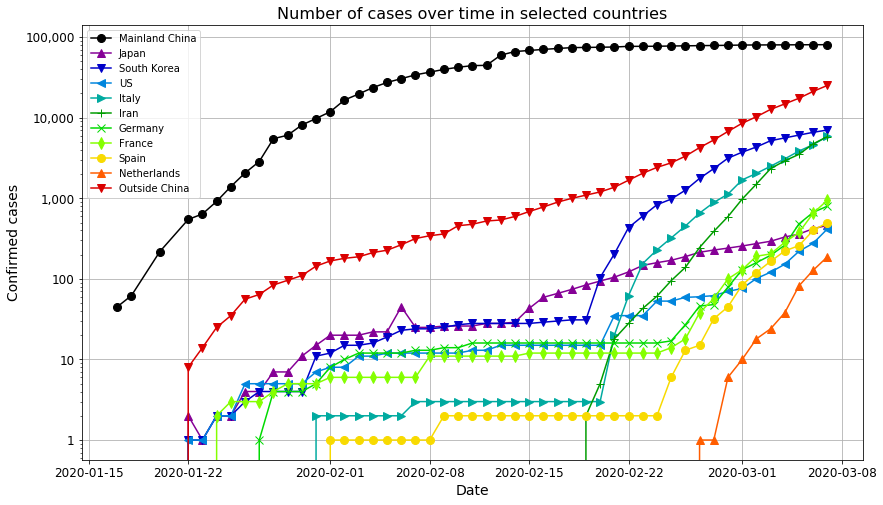

In [6]:
countries_to_plot = ["Mainland China", "Japan", "South Korea", "US", "Italy", "Iran", "Germany",
                     "France", "Spain", "Netherlands", "Outside China"]
markers = "o^v<>+xd"
m = len(markers)
cNorm = matplotlib.colors.Normalize(vmin=0, vmax=len(countries_to_plot))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)

for i, country in enumerate(countries_to_plot):
    plt.plot(by_country.loc[country, dates], markers[i%m]+"-", label=country, 
             markersize=8, color=scalarMap.to_rgba(i))
    
plt.legend()
plt.xlabel("Date", fontsize=14)
plt.ylabel("Confirmed cases", fontsize=14)
set_y_axis_format()
plt.grid()
locs, labels = plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of cases over time in selected countries", fontsize=16)
plt.show()

### Plot cases over days since start of local outbreak in selected countries

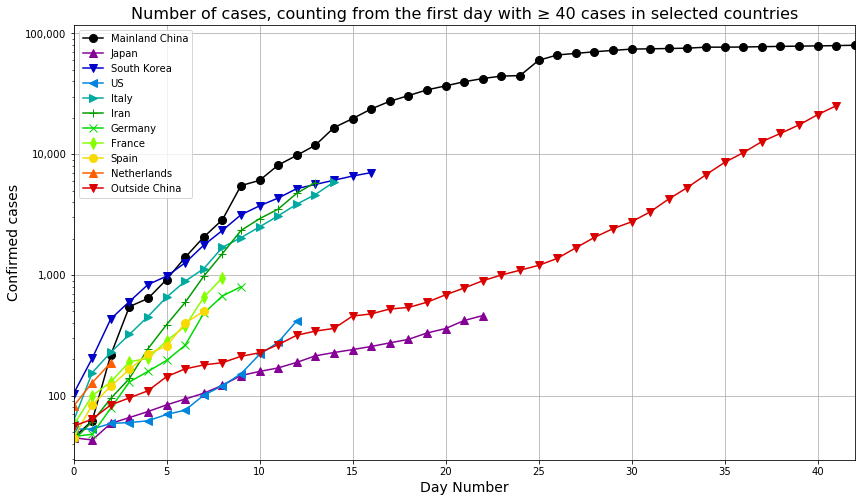

In [7]:
min_cases = 40
length = None

for i, country in enumerate(countries_to_plot):
    country_data = by_country.loc[country, dates]
    country_data = country_data[country_data >= min_cases]
    if country == "Outside China":
        length = len(country_data)
    day_nr = list(range(len(country_data)))
    plt.plot(day_nr, country_data, markers[i%m]+"-", label=country, markersize=8, color=scalarMap.to_rgba(i))
    
plt.legend()
plt.xlabel("Day Number", fontsize=14)
plt.xlim(0, length)
plt.ylabel("Confirmed cases", fontsize=14)
plt.grid()
locs, labels = plt.xticks()
set_y_axis_format()
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
plt.title(f"Number of cases, counting from the first day with ≥ {min_cases} cases in selected countries", fontsize=16)
plt.show()

### Smoothed growth factor

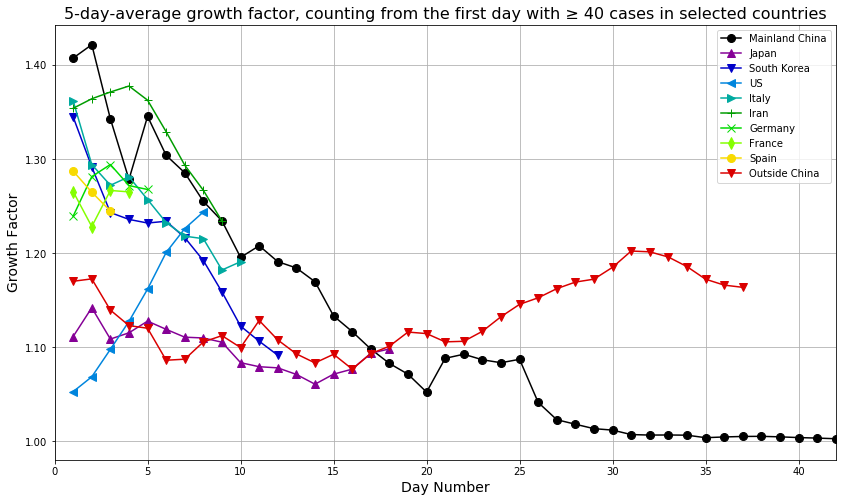

In [8]:
n_days = 5

for i, country in enumerate(countries_to_plot):
    country_data = by_country.loc[country, dates]
    country_data = country_data[country_data >= min_cases]
    country_data = country_data.diff() / country_data + 1
    country_data = np.convolve(country_data, np.ones(n_days)/n_days, mode="valid")
    day_nr = list(range(len(country_data)))
    if sum(pd.notnull(country_data)) > 0:
        plt.plot(day_nr, country_data, markers[i%m]+"-", label=country, markersize=8, color=scalarMap.to_rgba(i))
    
plt.legend()
plt.xlabel("Day Number", fontsize=14)
plt.xlim(0, length)
plt.ylabel("Growth Factor", fontsize=14)
plt.grid()
locs, labels = plt.xticks()
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.2f}"))
plt.title(f"{n_days}-day-average growth factor, counting from the first day with ≥ {min_cases} cases in selected countries", fontsize=16)
plt.show()

### Fit a logistic curve and extrapolate number of future cases

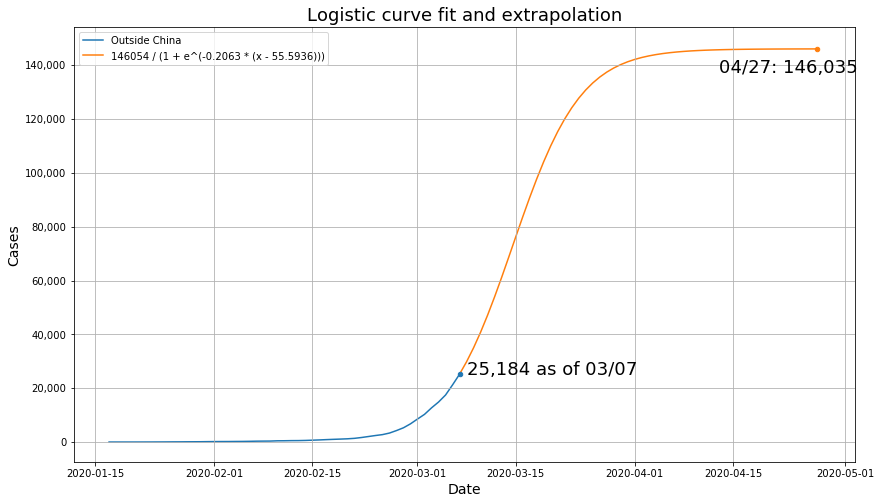

In [9]:
x = np.arange(100)
outside_china = by_country.loc["Outside China", :]
current_day = dates[-1]

def func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

[L, k, x0], _ =  curve_fit(func, np.arange(len(outside_china)), outside_china, p0=[1e7, 0.5, 65])

plt.plot(dates, outside_china, label="Outside China", markersize=3, zorder=1)

model_date_list = [current_day + datetime.timedelta(days = n+1) for n in range(-1, len(x) - len(dates))]
model_date_list = [mdates.date2num(x) for x in model_date_list]

n = len(dates)
logistic = L / (1 + np.exp(-k*(x[n-1:]-x0)))
plt.plot(model_date_list, logistic, label=f"{L:.0f} / (1 + e^(-{k:.4f} * (x - {x0:.4f})))", zorder=1)

plt.grid()
locs, labels = plt.xticks()

plt.legend()
plt.title("Logistic curve fit and extrapolation", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cases", fontsize=14)
plt.scatter(mdates.date2num(current_day), outside_china[-1], s=20, c="C00", zorder=2)
plt.annotate(f"{outside_china[-1]:,.0f} as of {datetime.datetime.strftime(current_day, '%m/%d')}", 
             (mdates.date2num(current_day)+1, outside_china[-1]), fontsize=18)

plt.scatter(model_date_list[-1], logistic[-1], s=20, c="C01", zorder=2)
plt.annotate(f"{mdates.num2date(model_date_list[-1]).strftime('%m/%d')}: {logistic[-1]:,.0f}", 
             (model_date_list[-1]-14, logistic[-1]*0.94), fontsize=18)
set_y_axis_format(False)
plt.show()